In [1]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
import os, torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Built with CUDA:", torch.version.cuda)     
print("CUDA available?:", torch.cuda.is_available())  
print("Device count:", torch.cuda.device_count())

CUDA_VISIBLE_DEVICES: 0
Built with CUDA: 12.4
CUDA available?: True
Device count: 1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from semisupervised import SemiSupervisedAutoEncoderOptions, SemiSupervisedAdversarialAutoencoder

In [4]:
from torch.utils.data import random_split

def configure_mnist(batch_size=100, val_size=10000):
    # transform: ToTensor + flatten
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    # full train + test datasets
    full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # split full_train → train_ds (60k - val_size) and val_ds (val_size)
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    # DataLoaders
    train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # (Optionally) extract raw tensors:
    X_train = torch.stack([x for x, _ in train_ds])
    Y_train = torch.tensor([y for _, y in train_ds])
    X_val   = torch.stack([x for x, _ in val_ds])
    Y_val   = torch.tensor([y for _, y in val_ds])
    X_test  = torch.stack([x for x, _ in test_ds])
    Y_test  = test_ds.targets.clone()

    return (X_train, X_val, X_test,
            Y_train, Y_val, Y_test,
            train_loader, val_loader, test_loader)

In [5]:
(X_train, X_val, X_test, Y_train, Y_val, Y_test, train_loader, val_loader, test_loader) = configure_mnist()

print(Y_train.max())
print(Y_train.min())

tensor(9)
tensor(0)


In [78]:
NUM_EPOCHS = 500
GAUSSIAN_NOISE = True
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 10
PRIOR_STD = 1.0
RESULT_FOLDER = 'semisupervised_results/500_epochs_adam_results_run_2_noise'

recon_loss = nn.MSELoss()
init_recon_lr = 0.001 #0.01

semi_sup_loss = nn.CrossEntropyLoss()
init_semi_sup_lr = 0.001 #0.1

init_gen_lr = init_disc_lr = 0.001 #0.1
use_decoder_sigmoid = True

In [7]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = SemiSupervisedAdversarialAutoencoder(options);

In [8]:
model.train_mbgd(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=NUM_EPOCHS,
    prior_std=PRIOR_STD,
    result_folder=RESULT_FOLDER,
    add_gaussian_noise=GAUSSIAN_NOISE
)

Epoch [1/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500 — Recon: 0.1538, Disc_Cat: 0.4298, Gen_Cat: 4.5980, Disc_Style: 1.2685, Gen_Style: 2.6257, SemiSup: 4.0240
Validation Accuracy: 39.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [2/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/500 — Recon: 0.1321, Disc_Cat: 1.0010, Gen_Cat: 1.9300, Disc_Style: 1.6699, Gen_Style: 1.5854, SemiSup: 1.5737
Validation Accuracy: 88.35%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [3/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/500 — Recon: 0.1206, Disc_Cat: 1.2465, Gen_Cat: 1.4559, Disc_Style: 1.4506, Gen_Style: 0.9587, SemiSup: 0.5526
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [4/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/500 — Recon: 0.1150, Disc_Cat: 1.2844, Gen_Cat: 1.2887, Disc_Style: 1.3917, Gen_Style: 0.8376, SemiSup: 0.4066
Validation Accuracy: 95.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [5/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/500 — Recon: 0.1119, Disc_Cat: 1.2973, Gen_Cat: 1.1747, Disc_Style: 1.3767, Gen_Style: 0.7524, SemiSup: 0.3228
Validation Accuracy: 95.25%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [6/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/500 — Recon: 0.1113, Disc_Cat: 1.3002, Gen_Cat: 1.1681, Disc_Style: 1.3899, Gen_Style: 0.7185, SemiSup: 0.2978
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [7/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/500 — Recon: 0.1106, Disc_Cat: 1.3020, Gen_Cat: 1.1734, Disc_Style: 1.3888, Gen_Style: 0.7114, SemiSup: 0.2940
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [8/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/500 — Recon: 0.1113, Disc_Cat: 1.3068, Gen_Cat: 1.1863, Disc_Style: 1.3935, Gen_Style: 0.7094, SemiSup: 0.3031
Validation Accuracy: 95.65%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [9/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/500 — Recon: 0.1097, Disc_Cat: 1.3158, Gen_Cat: 1.1765, Disc_Style: 1.3874, Gen_Style: 0.6926, SemiSup: 0.3153
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [10/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/500 — Recon: 0.1106, Disc_Cat: 1.3161, Gen_Cat: 1.2229, Disc_Style: 1.3961, Gen_Style: 0.6989, SemiSup: 0.3469
Validation Accuracy: 96.30%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [11/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11/500 — Recon: 0.1081, Disc_Cat: 1.3271, Gen_Cat: 1.1843, Disc_Style: 1.3872, Gen_Style: 0.6959, SemiSup: 0.2883
Validation Accuracy: 96.54%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [12/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12/500 — Recon: 0.1133, Disc_Cat: 1.3140, Gen_Cat: 1.3269, Disc_Style: 1.4037, Gen_Style: 0.7111, SemiSup: 0.3612
Validation Accuracy: 96.14%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [13/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13/500 — Recon: 0.1099, Disc_Cat: 1.3225, Gen_Cat: 1.2943, Disc_Style: 1.3914, Gen_Style: 0.7284, SemiSup: 0.2863
Validation Accuracy: 97.09%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [14/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14/500 — Recon: 0.1069, Disc_Cat: 1.3362, Gen_Cat: 1.1677, Disc_Style: 1.3873, Gen_Style: 0.6961, SemiSup: 0.2451
Validation Accuracy: 96.80%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [15/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15/500 — Recon: 0.1066, Disc_Cat: 1.3343, Gen_Cat: 1.1964, Disc_Style: 1.3864, Gen_Style: 0.6937, SemiSup: 0.2551
Validation Accuracy: 96.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [16/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16/500 — Recon: 0.1066, Disc_Cat: 1.3356, Gen_Cat: 1.2101, Disc_Style: 1.3871, Gen_Style: 0.6938, SemiSup: 0.2600
Validation Accuracy: 96.83%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [17/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17/500 — Recon: 0.1057, Disc_Cat: 1.3386, Gen_Cat: 1.1907, Disc_Style: 1.3867, Gen_Style: 0.6934, SemiSup: 0.2421
Validation Accuracy: 97.20%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [18/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18/500 — Recon: 0.1056, Disc_Cat: 1.3382, Gen_Cat: 1.2153, Disc_Style: 1.3869, Gen_Style: 0.6937, SemiSup: 0.2124
Validation Accuracy: 97.38%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [19/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19/500 — Recon: 0.1202, Disc_Cat: 1.1927, Gen_Cat: 2.7753, Disc_Style: 1.4504, Gen_Style: 0.8736, SemiSup: 0.7654
Validation Accuracy: 86.48%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [20/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20/500 — Recon: 0.1184, Disc_Cat: 1.2447, Gen_Cat: 2.2430, Disc_Style: 1.3382, Gen_Style: 0.8381, SemiSup: 0.5671
Validation Accuracy: 95.54%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [21/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 21/500 — Recon: 0.1097, Disc_Cat: 1.3050, Gen_Cat: 1.5862, Disc_Style: 1.3890, Gen_Style: 0.7326, SemiSup: 0.3252
Validation Accuracy: 96.47%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [22/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 22/500 — Recon: 0.1071, Disc_Cat: 1.3231, Gen_Cat: 1.3884, Disc_Style: 1.3869, Gen_Style: 0.6978, SemiSup: 0.2649
Validation Accuracy: 97.11%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [23/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 23/500 — Recon: 0.1060, Disc_Cat: 1.3257, Gen_Cat: 1.4086, Disc_Style: 1.3865, Gen_Style: 0.6933, SemiSup: 0.2397
Validation Accuracy: 97.12%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [24/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 24/500 — Recon: 0.1056, Disc_Cat: 1.3316, Gen_Cat: 1.3358, Disc_Style: 1.3868, Gen_Style: 0.6928, SemiSup: 0.2373
Validation Accuracy: 96.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [25/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 25/500 — Recon: 0.1061, Disc_Cat: 1.3330, Gen_Cat: 1.3097, Disc_Style: 1.3877, Gen_Style: 0.6949, SemiSup: 0.2354
Validation Accuracy: 97.44%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [26/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 26/500 — Recon: 0.1055, Disc_Cat: 1.3360, Gen_Cat: 1.3048, Disc_Style: 1.3862, Gen_Style: 0.6932, SemiSup: 0.2816
Validation Accuracy: 96.70%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [27/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 27/500 — Recon: 0.1126, Disc_Cat: 1.3337, Gen_Cat: 1.3830, Disc_Style: 1.4673, Gen_Style: 0.7951, SemiSup: 0.3978
Validation Accuracy: 90.75%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [28/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 28/500 — Recon: 0.1124, Disc_Cat: 1.3257, Gen_Cat: 1.4995, Disc_Style: 1.3491, Gen_Style: 1.0234, SemiSup: 0.3601
Validation Accuracy: 97.14%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [29/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 29/500 — Recon: 0.1064, Disc_Cat: 1.3395, Gen_Cat: 1.2906, Disc_Style: 1.3970, Gen_Style: 0.7982, SemiSup: 0.2298
Validation Accuracy: 97.50%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [30/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 30/500 — Recon: 0.1059, Disc_Cat: 1.3375, Gen_Cat: 1.3589, Disc_Style: 1.3848, Gen_Style: 0.7185, SemiSup: 0.2115
Validation Accuracy: 97.06%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [31/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 31/500 — Recon: 0.1089, Disc_Cat: 1.3247, Gen_Cat: 1.5975, Disc_Style: 1.3866, Gen_Style: 0.7343, SemiSup: 0.2282
Validation Accuracy: 97.55%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [32/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 32/500 — Recon: 0.1047, Disc_Cat: 1.3376, Gen_Cat: 1.4153, Disc_Style: 1.3863, Gen_Style: 0.7021, SemiSup: 0.1709
Validation Accuracy: 97.76%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [33/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 33/500 — Recon: 0.1042, Disc_Cat: 1.3405, Gen_Cat: 1.3458, Disc_Style: 1.3863, Gen_Style: 0.6940, SemiSup: 0.1767
Validation Accuracy: 97.68%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [34/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 34/500 — Recon: 0.1040, Disc_Cat: 1.3425, Gen_Cat: 1.3238, Disc_Style: 1.3856, Gen_Style: 0.6933, SemiSup: 0.1727
Validation Accuracy: 97.54%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [35/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 35/500 — Recon: 0.1051, Disc_Cat: 1.3419, Gen_Cat: 1.3579, Disc_Style: 1.3830, Gen_Style: 0.6943, SemiSup: 0.2147
Validation Accuracy: 97.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [36/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 36/500 — Recon: 0.1062, Disc_Cat: 1.3352, Gen_Cat: 1.5106, Disc_Style: 1.3867, Gen_Style: 0.6963, SemiSup: 0.1727
Validation Accuracy: 97.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [37/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 37/500 — Recon: 0.1068, Disc_Cat: 1.3356, Gen_Cat: 1.4689, Disc_Style: 1.3876, Gen_Style: 0.6953, SemiSup: 0.1430
Validation Accuracy: 97.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [38/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 38/500 — Recon: 0.1042, Disc_Cat: 1.3405, Gen_Cat: 1.3987, Disc_Style: 1.3864, Gen_Style: 0.6934, SemiSup: 0.1219
Validation Accuracy: 98.12%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [39/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 39/500 — Recon: 0.1036, Disc_Cat: 1.3424, Gen_Cat: 1.4007, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.1229
Validation Accuracy: 98.09%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [40/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 40/500 — Recon: 0.1036, Disc_Cat: 1.3444, Gen_Cat: 1.3661, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.1190
Validation Accuracy: 98.05%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [41/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 41/500 — Recon: 0.1036, Disc_Cat: 1.3457, Gen_Cat: 1.3530, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.1183
Validation Accuracy: 98.21%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [42/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 42/500 — Recon: 0.1055, Disc_Cat: 1.3429, Gen_Cat: 1.3991, Disc_Style: 1.3877, Gen_Style: 0.6937, SemiSup: 0.1198
Validation Accuracy: 97.86%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [43/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 43/500 — Recon: 0.1039, Disc_Cat: 1.3407, Gen_Cat: 1.4576, Disc_Style: 1.3864, Gen_Style: 0.6931, SemiSup: 0.1121
Validation Accuracy: 97.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [44/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 44/500 — Recon: 0.1030, Disc_Cat: 1.3467, Gen_Cat: 1.3603, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.1074
Validation Accuracy: 98.34%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [45/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 45/500 — Recon: 0.1029, Disc_Cat: 1.3468, Gen_Cat: 1.3874, Disc_Style: 1.3864, Gen_Style: 0.6931, SemiSup: 0.0972
Validation Accuracy: 98.39%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [46/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 46/500 — Recon: 0.1027, Disc_Cat: 1.3491, Gen_Cat: 1.3303, Disc_Style: 1.3864, Gen_Style: 0.6931, SemiSup: 0.1009
Validation Accuracy: 98.23%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [47/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 47/500 — Recon: 0.1026, Disc_Cat: 1.3498, Gen_Cat: 1.3370, Disc_Style: 1.3866, Gen_Style: 0.6932, SemiSup: 0.0931
Validation Accuracy: 98.18%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [48/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 48/500 — Recon: 0.1030, Disc_Cat: 1.3503, Gen_Cat: 1.3076, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0897
Validation Accuracy: 98.26%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [49/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 49/500 — Recon: 0.1029, Disc_Cat: 1.3457, Gen_Cat: 1.4351, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0933
Validation Accuracy: 98.52%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [50/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 50/500 — Recon: 0.1022, Disc_Cat: 1.3510, Gen_Cat: 1.3079, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0873
Validation Accuracy: 98.39%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_epoch_50_*.pth
Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [51/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 51/500 — Recon: 0.1013, Disc_Cat: 1.3594, Gen_Cat: 1.1031, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0556
Validation Accuracy: 98.75%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [52/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 52/500 — Recon: 0.1012, Disc_Cat: 1.3582, Gen_Cat: 1.1440, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0473
Validation Accuracy: 98.83%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [53/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 53/500 — Recon: 0.1012, Disc_Cat: 1.3535, Gen_Cat: 1.2116, Disc_Style: 1.3862, Gen_Style: 0.6932, SemiSup: 0.0438
Validation Accuracy: 98.79%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [54/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 54/500 — Recon: 0.1012, Disc_Cat: 1.3542, Gen_Cat: 1.2026, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0456
Validation Accuracy: 98.76%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [55/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 55/500 — Recon: 0.1013, Disc_Cat: 1.3528, Gen_Cat: 1.2307, Disc_Style: 1.3861, Gen_Style: 0.6934, SemiSup: 0.0425
Validation Accuracy: 98.80%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [56/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 56/500 — Recon: 0.1014, Disc_Cat: 1.3531, Gen_Cat: 1.2271, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0434
Validation Accuracy: 98.78%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [57/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 57/500 — Recon: 0.1011, Disc_Cat: 1.3533, Gen_Cat: 1.2141, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0466
Validation Accuracy: 98.77%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [58/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 58/500 — Recon: 0.1010, Disc_Cat: 1.3548, Gen_Cat: 1.2183, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0397
Validation Accuracy: 98.75%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [59/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 59/500 — Recon: 0.1009, Disc_Cat: 1.3558, Gen_Cat: 1.2050, Disc_Style: 1.3862, Gen_Style: 0.6932, SemiSup: 0.0384
Validation Accuracy: 98.76%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [60/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 60/500 — Recon: 0.1009, Disc_Cat: 1.3552, Gen_Cat: 1.2141, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0413
Validation Accuracy: 98.80%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [61/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 61/500 — Recon: 0.1009, Disc_Cat: 1.3546, Gen_Cat: 1.2372, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0385
Validation Accuracy: 98.83%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [62/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 62/500 — Recon: 0.1008, Disc_Cat: 1.3537, Gen_Cat: 1.2477, Disc_Style: 1.3862, Gen_Style: 0.6932, SemiSup: 0.0404
Validation Accuracy: 98.80%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [63/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 63/500 — Recon: 0.1009, Disc_Cat: 1.3525, Gen_Cat: 1.2586, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0370
Validation Accuracy: 98.81%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [64/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 64/500 — Recon: 0.1010, Disc_Cat: 1.3533, Gen_Cat: 1.2546, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0360
Validation Accuracy: 98.81%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [65/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 65/500 — Recon: 0.1009, Disc_Cat: 1.3517, Gen_Cat: 1.2804, Disc_Style: 1.3865, Gen_Style: 0.6931, SemiSup: 0.0377
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [66/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 66/500 — Recon: 0.1008, Disc_Cat: 1.3531, Gen_Cat: 1.2476, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0354
Validation Accuracy: 98.82%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [67/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 67/500 — Recon: 0.1008, Disc_Cat: 1.3541, Gen_Cat: 1.2655, Disc_Style: 1.3862, Gen_Style: 0.6932, SemiSup: 0.0332
Validation Accuracy: 98.82%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [68/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 68/500 — Recon: 0.1008, Disc_Cat: 1.3546, Gen_Cat: 1.2679, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0356
Validation Accuracy: 98.79%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [69/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 69/500 — Recon: 0.1008, Disc_Cat: 1.3532, Gen_Cat: 1.2780, Disc_Style: 1.3861, Gen_Style: 0.6934, SemiSup: 0.0371
Validation Accuracy: 98.75%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [70/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 70/500 — Recon: 0.1013, Disc_Cat: 1.3530, Gen_Cat: 1.2815, Disc_Style: 1.3865, Gen_Style: 0.6934, SemiSup: 0.0382
Validation Accuracy: 98.77%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [71/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 71/500 — Recon: 0.1012, Disc_Cat: 1.3538, Gen_Cat: 1.2717, Disc_Style: 1.3864, Gen_Style: 0.6934, SemiSup: 0.0339
Validation Accuracy: 98.78%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [72/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 72/500 — Recon: 0.1014, Disc_Cat: 1.3539, Gen_Cat: 1.2854, Disc_Style: 1.3868, Gen_Style: 0.6934, SemiSup: 0.0404
Validation Accuracy: 98.83%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [73/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 73/500 — Recon: 0.1013, Disc_Cat: 1.3527, Gen_Cat: 1.3152, Disc_Style: 1.3857, Gen_Style: 0.6938, SemiSup: 0.0369
Validation Accuracy: 98.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [74/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 74/500 — Recon: 0.1015, Disc_Cat: 1.3551, Gen_Cat: 1.2785, Disc_Style: 1.3872, Gen_Style: 0.6934, SemiSup: 0.0373
Validation Accuracy: 98.83%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [75/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 75/500 — Recon: 0.1013, Disc_Cat: 1.3554, Gen_Cat: 1.2922, Disc_Style: 1.3864, Gen_Style: 0.6930, SemiSup: 0.0344
Validation Accuracy: 98.74%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [76/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 76/500 — Recon: 0.1016, Disc_Cat: 1.3550, Gen_Cat: 1.2884, Disc_Style: 1.3867, Gen_Style: 0.6938, SemiSup: 0.0363
Validation Accuracy: 98.79%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [77/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 77/500 — Recon: 0.1013, Disc_Cat: 1.3541, Gen_Cat: 1.3033, Disc_Style: 1.3858, Gen_Style: 0.6937, SemiSup: 0.0328
Validation Accuracy: 98.79%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [78/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 78/500 — Recon: 0.1015, Disc_Cat: 1.3553, Gen_Cat: 1.2989, Disc_Style: 1.3857, Gen_Style: 0.6939, SemiSup: 0.0378
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [79/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 79/500 — Recon: 0.1015, Disc_Cat: 1.3560, Gen_Cat: 1.2904, Disc_Style: 1.3868, Gen_Style: 0.6935, SemiSup: 0.0376
Validation Accuracy: 98.82%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [80/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 80/500 — Recon: 0.1013, Disc_Cat: 1.3553, Gen_Cat: 1.2958, Disc_Style: 1.3865, Gen_Style: 0.6931, SemiSup: 0.0348
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [81/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 81/500 — Recon: 0.1012, Disc_Cat: 1.3572, Gen_Cat: 1.2728, Disc_Style: 1.3865, Gen_Style: 0.6937, SemiSup: 0.0347
Validation Accuracy: 98.79%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [82/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 82/500 — Recon: 0.1011, Disc_Cat: 1.3584, Gen_Cat: 1.2561, Disc_Style: 1.3862, Gen_Style: 0.6930, SemiSup: 0.0316
Validation Accuracy: 98.82%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [83/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 83/500 — Recon: 0.1011, Disc_Cat: 1.3567, Gen_Cat: 1.2965, Disc_Style: 1.3862, Gen_Style: 0.6933, SemiSup: 0.0357
Validation Accuracy: 98.77%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [84/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 84/500 — Recon: 0.1010, Disc_Cat: 1.3571, Gen_Cat: 1.3028, Disc_Style: 1.3861, Gen_Style: 0.6934, SemiSup: 0.0332
Validation Accuracy: 98.76%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [85/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 85/500 — Recon: 0.1011, Disc_Cat: 1.3581, Gen_Cat: 1.2905, Disc_Style: 1.3862, Gen_Style: 0.6933, SemiSup: 0.0337
Validation Accuracy: 98.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [86/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 86/500 — Recon: 0.1010, Disc_Cat: 1.3575, Gen_Cat: 1.2943, Disc_Style: 1.3861, Gen_Style: 0.6933, SemiSup: 0.0340
Validation Accuracy: 98.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [87/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 87/500 — Recon: 0.1011, Disc_Cat: 1.3584, Gen_Cat: 1.2838, Disc_Style: 1.3862, Gen_Style: 0.6932, SemiSup: 0.0327
Validation Accuracy: 98.74%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [88/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 88/500 — Recon: 0.1010, Disc_Cat: 1.3581, Gen_Cat: 1.3019, Disc_Style: 1.3862, Gen_Style: 0.6935, SemiSup: 0.0322
Validation Accuracy: 98.77%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [89/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 89/500 — Recon: 0.1010, Disc_Cat: 1.3575, Gen_Cat: 1.3192, Disc_Style: 1.3863, Gen_Style: 0.6930, SemiSup: 0.0323
Validation Accuracy: 98.81%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [90/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 90/500 — Recon: 0.1010, Disc_Cat: 1.3572, Gen_Cat: 1.3143, Disc_Style: 1.3863, Gen_Style: 0.6934, SemiSup: 0.0308
Validation Accuracy: 98.82%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [91/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 91/500 — Recon: 0.1011, Disc_Cat: 1.3586, Gen_Cat: 1.2991, Disc_Style: 1.3863, Gen_Style: 0.6937, SemiSup: 0.0320
Validation Accuracy: 98.86%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [92/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 92/500 — Recon: 0.1009, Disc_Cat: 1.3585, Gen_Cat: 1.3019, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0305
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [93/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 93/500 — Recon: 0.1010, Disc_Cat: 1.3580, Gen_Cat: 1.2970, Disc_Style: 1.3863, Gen_Style: 0.6935, SemiSup: 0.0287
Validation Accuracy: 98.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [94/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 94/500 — Recon: 0.1008, Disc_Cat: 1.3588, Gen_Cat: 1.2992, Disc_Style: 1.3864, Gen_Style: 0.6929, SemiSup: 0.0281
Validation Accuracy: 98.80%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [95/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 95/500 — Recon: 0.1008, Disc_Cat: 1.3580, Gen_Cat: 1.3222, Disc_Style: 1.3861, Gen_Style: 0.6933, SemiSup: 0.0302
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [96/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 96/500 — Recon: 0.1011, Disc_Cat: 1.3585, Gen_Cat: 1.3207, Disc_Style: 1.3864, Gen_Style: 0.6936, SemiSup: 0.0308
Validation Accuracy: 98.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [97/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 97/500 — Recon: 0.1010, Disc_Cat: 1.3588, Gen_Cat: 1.3123, Disc_Style: 1.3865, Gen_Style: 0.6933, SemiSup: 0.0320
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [98/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 98/500 — Recon: 0.1011, Disc_Cat: 1.3589, Gen_Cat: 1.3205, Disc_Style: 1.3864, Gen_Style: 0.6934, SemiSup: 0.0277
Validation Accuracy: 98.82%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [99/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 99/500 — Recon: 0.1010, Disc_Cat: 1.3577, Gen_Cat: 1.3524, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0292
Validation Accuracy: 98.85%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [100/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 100/500 — Recon: 0.1010, Disc_Cat: 1.3590, Gen_Cat: 1.3038, Disc_Style: 1.3864, Gen_Style: 0.6934, SemiSup: 0.0308
Validation Accuracy: 98.79%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_epoch_100_*.pth
Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [101/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 101/500 — Recon: 0.1009, Disc_Cat: 1.3593, Gen_Cat: 1.3022, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0284
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [102/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 102/500 — Recon: 0.1010, Disc_Cat: 1.3597, Gen_Cat: 1.3233, Disc_Style: 1.3862, Gen_Style: 0.6930, SemiSup: 0.0284
Validation Accuracy: 98.85%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [103/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 103/500 — Recon: 0.1012, Disc_Cat: 1.3577, Gen_Cat: 1.3386, Disc_Style: 1.3865, Gen_Style: 0.6941, SemiSup: 0.0276
Validation Accuracy: 98.77%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [104/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 104/500 — Recon: 0.1011, Disc_Cat: 1.3588, Gen_Cat: 1.3193, Disc_Style: 1.3864, Gen_Style: 0.6929, SemiSup: 0.0285
Validation Accuracy: 98.81%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [105/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 105/500 — Recon: 0.1011, Disc_Cat: 1.3593, Gen_Cat: 1.3359, Disc_Style: 1.3864, Gen_Style: 0.6936, SemiSup: 0.0269
Validation Accuracy: 98.83%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [106/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 106/500 — Recon: 0.1009, Disc_Cat: 1.3593, Gen_Cat: 1.3358, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0270
Validation Accuracy: 98.83%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [107/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 107/500 — Recon: 0.1009, Disc_Cat: 1.3599, Gen_Cat: 1.3199, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0284
Validation Accuracy: 98.86%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [108/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 108/500 — Recon: 0.1009, Disc_Cat: 1.3598, Gen_Cat: 1.3330, Disc_Style: 1.3863, Gen_Style: 0.6934, SemiSup: 0.0237
Validation Accuracy: 98.86%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [109/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 109/500 — Recon: 0.1010, Disc_Cat: 1.3591, Gen_Cat: 1.3440, Disc_Style: 1.3863, Gen_Style: 0.6937, SemiSup: 0.0240
Validation Accuracy: 98.73%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [110/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 110/500 — Recon: 0.1011, Disc_Cat: 1.3605, Gen_Cat: 1.3196, Disc_Style: 1.3864, Gen_Style: 0.6929, SemiSup: 0.0256
Validation Accuracy: 98.86%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [111/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 111/500 — Recon: 0.1010, Disc_Cat: 1.3595, Gen_Cat: 1.3328, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0248
Validation Accuracy: 98.73%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [112/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 112/500 — Recon: 0.1010, Disc_Cat: 1.3610, Gen_Cat: 1.3182, Disc_Style: 1.3864, Gen_Style: 0.6937, SemiSup: 0.0257
Validation Accuracy: 98.76%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [113/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 113/500 — Recon: 0.1009, Disc_Cat: 1.3609, Gen_Cat: 1.3065, Disc_Style: 1.3864, Gen_Style: 0.6931, SemiSup: 0.0290
Validation Accuracy: 98.73%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [114/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 114/500 — Recon: 0.1010, Disc_Cat: 1.3602, Gen_Cat: 1.3408, Disc_Style: 1.3864, Gen_Style: 0.6934, SemiSup: 0.0236
Validation Accuracy: 98.85%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [115/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 115/500 — Recon: 0.1010, Disc_Cat: 1.3592, Gen_Cat: 1.3458, Disc_Style: 1.3863, Gen_Style: 0.6934, SemiSup: 0.0256
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [116/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 116/500 — Recon: 0.1010, Disc_Cat: 1.3605, Gen_Cat: 1.3303, Disc_Style: 1.3863, Gen_Style: 0.6929, SemiSup: 0.0234
Validation Accuracy: 98.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [117/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 117/500 — Recon: 0.1010, Disc_Cat: 1.3600, Gen_Cat: 1.3443, Disc_Style: 1.3862, Gen_Style: 0.6928, SemiSup: 0.0268
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [118/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 118/500 — Recon: 0.1011, Disc_Cat: 1.3599, Gen_Cat: 1.3439, Disc_Style: 1.3862, Gen_Style: 0.6935, SemiSup: 0.0230
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [119/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 119/500 — Recon: 0.1012, Disc_Cat: 1.3611, Gen_Cat: 1.3337, Disc_Style: 1.3866, Gen_Style: 0.6937, SemiSup: 0.0265
Validation Accuracy: 98.83%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [120/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 120/500 — Recon: 0.1011, Disc_Cat: 1.3608, Gen_Cat: 1.3529, Disc_Style: 1.3862, Gen_Style: 0.6946, SemiSup: 0.0254
Validation Accuracy: 98.80%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [121/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 121/500 — Recon: 0.1011, Disc_Cat: 1.3596, Gen_Cat: 1.3403, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0239
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [122/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 122/500 — Recon: 0.1009, Disc_Cat: 1.3607, Gen_Cat: 1.3343, Disc_Style: 1.3861, Gen_Style: 0.6932, SemiSup: 0.0240
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [123/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 123/500 — Recon: 0.1012, Disc_Cat: 1.3604, Gen_Cat: 1.3488, Disc_Style: 1.3864, Gen_Style: 0.6941, SemiSup: 0.0226
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [124/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 124/500 — Recon: 0.1009, Disc_Cat: 1.3604, Gen_Cat: 1.3652, Disc_Style: 1.3862, Gen_Style: 0.6925, SemiSup: 0.0234
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [125/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 125/500 — Recon: 0.1009, Disc_Cat: 1.3609, Gen_Cat: 1.3385, Disc_Style: 1.3860, Gen_Style: 0.6934, SemiSup: 0.0227
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [126/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 126/500 — Recon: 0.1009, Disc_Cat: 1.3599, Gen_Cat: 1.3692, Disc_Style: 1.3858, Gen_Style: 0.6946, SemiSup: 0.0251
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [127/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 127/500 — Recon: 0.1009, Disc_Cat: 1.3609, Gen_Cat: 1.3317, Disc_Style: 1.3859, Gen_Style: 0.6925, SemiSup: 0.0241
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [128/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 128/500 — Recon: 0.1011, Disc_Cat: 1.3608, Gen_Cat: 1.3574, Disc_Style: 1.3866, Gen_Style: 0.6948, SemiSup: 0.0236
Validation Accuracy: 98.81%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [129/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 129/500 — Recon: 0.1009, Disc_Cat: 1.3612, Gen_Cat: 1.3539, Disc_Style: 1.3861, Gen_Style: 0.6931, SemiSup: 0.0213
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [130/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 130/500 — Recon: 0.1009, Disc_Cat: 1.3619, Gen_Cat: 1.3429, Disc_Style: 1.3860, Gen_Style: 0.6936, SemiSup: 0.0230
Validation Accuracy: 98.86%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [131/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 131/500 — Recon: 0.1009, Disc_Cat: 1.3616, Gen_Cat: 1.3426, Disc_Style: 1.3860, Gen_Style: 0.6941, SemiSup: 0.0229
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [132/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 132/500 — Recon: 0.1009, Disc_Cat: 1.3612, Gen_Cat: 1.3571, Disc_Style: 1.3863, Gen_Style: 0.6939, SemiSup: 0.0217
Validation Accuracy: 98.85%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [133/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 133/500 — Recon: 0.1008, Disc_Cat: 1.3611, Gen_Cat: 1.3545, Disc_Style: 1.3860, Gen_Style: 0.6935, SemiSup: 0.0201
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [134/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 134/500 — Recon: 0.1007, Disc_Cat: 1.3610, Gen_Cat: 1.3265, Disc_Style: 1.3860, Gen_Style: 0.6934, SemiSup: 0.0217
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [135/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 135/500 — Recon: 0.1009, Disc_Cat: 1.3613, Gen_Cat: 1.3788, Disc_Style: 1.3859, Gen_Style: 0.6930, SemiSup: 0.0222
Validation Accuracy: 98.86%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [136/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 136/500 — Recon: 0.1009, Disc_Cat: 1.3612, Gen_Cat: 1.3551, Disc_Style: 1.3866, Gen_Style: 0.6952, SemiSup: 0.0222
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [137/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 137/500 — Recon: 0.1009, Disc_Cat: 1.3609, Gen_Cat: 1.3653, Disc_Style: 1.3865, Gen_Style: 0.6925, SemiSup: 0.0230
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [138/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 138/500 — Recon: 0.1007, Disc_Cat: 1.3609, Gen_Cat: 1.3492, Disc_Style: 1.3859, Gen_Style: 0.6936, SemiSup: 0.0181
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [139/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 139/500 — Recon: 0.1007, Disc_Cat: 1.3604, Gen_Cat: 1.3814, Disc_Style: 1.3858, Gen_Style: 0.6937, SemiSup: 0.0221
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [140/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 140/500 — Recon: 0.1010, Disc_Cat: 1.3616, Gen_Cat: 1.3696, Disc_Style: 1.3866, Gen_Style: 0.6948, SemiSup: 0.0183
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [141/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 141/500 — Recon: 0.1009, Disc_Cat: 1.3619, Gen_Cat: 1.3496, Disc_Style: 1.3861, Gen_Style: 0.6930, SemiSup: 0.0185
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [142/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 142/500 — Recon: 0.1008, Disc_Cat: 1.3609, Gen_Cat: 1.3650, Disc_Style: 1.3862, Gen_Style: 0.6945, SemiSup: 0.0209
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [143/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 143/500 — Recon: 0.1007, Disc_Cat: 1.3631, Gen_Cat: 1.3141, Disc_Style: 1.3859, Gen_Style: 0.6942, SemiSup: 0.0214
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [144/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 144/500 — Recon: 0.1009, Disc_Cat: 1.3635, Gen_Cat: 1.3350, Disc_Style: 1.3863, Gen_Style: 0.6928, SemiSup: 0.0212
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [145/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 145/500 — Recon: 0.1008, Disc_Cat: 1.3633, Gen_Cat: 1.3284, Disc_Style: 1.3861, Gen_Style: 0.6938, SemiSup: 0.0195
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [146/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 146/500 — Recon: 0.1008, Disc_Cat: 1.3619, Gen_Cat: 1.3650, Disc_Style: 1.3861, Gen_Style: 0.6930, SemiSup: 0.0192
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [147/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 147/500 — Recon: 0.1008, Disc_Cat: 1.3630, Gen_Cat: 1.3238, Disc_Style: 1.3861, Gen_Style: 0.6943, SemiSup: 0.0194
Validation Accuracy: 98.85%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [148/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 148/500 — Recon: 0.1008, Disc_Cat: 1.3623, Gen_Cat: 1.3297, Disc_Style: 1.3866, Gen_Style: 0.6932, SemiSup: 0.0193
Validation Accuracy: 98.78%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [149/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 149/500 — Recon: 0.1007, Disc_Cat: 1.3625, Gen_Cat: 1.3536, Disc_Style: 1.3860, Gen_Style: 0.6933, SemiSup: 0.0212
Validation Accuracy: 98.86%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [150/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 150/500 — Recon: 0.1008, Disc_Cat: 1.3628, Gen_Cat: 1.3557, Disc_Style: 1.3858, Gen_Style: 0.6938, SemiSup: 0.0215
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_epoch_150_*.pth
Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [151/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 151/500 — Recon: 0.1010, Disc_Cat: 1.3622, Gen_Cat: 1.3671, Disc_Style: 1.3869, Gen_Style: 0.6940, SemiSup: 0.0189
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [152/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 152/500 — Recon: 0.1006, Disc_Cat: 1.3626, Gen_Cat: 1.3339, Disc_Style: 1.3860, Gen_Style: 0.6943, SemiSup: 0.0194
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [153/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 153/500 — Recon: 0.1008, Disc_Cat: 1.3639, Gen_Cat: 1.3375, Disc_Style: 1.3863, Gen_Style: 0.6928, SemiSup: 0.0177
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [154/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 154/500 — Recon: 0.1007, Disc_Cat: 1.3639, Gen_Cat: 1.3193, Disc_Style: 1.3862, Gen_Style: 0.6937, SemiSup: 0.0227
Validation Accuracy: 98.85%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [155/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 155/500 — Recon: 0.1009, Disc_Cat: 1.3617, Gen_Cat: 1.3645, Disc_Style: 1.3863, Gen_Style: 0.6934, SemiSup: 0.0164
Validation Accuracy: 98.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [156/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 156/500 — Recon: 0.1007, Disc_Cat: 1.3616, Gen_Cat: 1.3611, Disc_Style: 1.3863, Gen_Style: 0.6939, SemiSup: 0.0198
Validation Accuracy: 98.83%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [157/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 157/500 — Recon: 0.1007, Disc_Cat: 1.3633, Gen_Cat: 1.3421, Disc_Style: 1.3862, Gen_Style: 0.6937, SemiSup: 0.0211
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [158/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 158/500 — Recon: 0.1008, Disc_Cat: 1.3624, Gen_Cat: 1.3823, Disc_Style: 1.3866, Gen_Style: 0.6935, SemiSup: 0.0187
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [159/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 159/500 — Recon: 0.1006, Disc_Cat: 1.3628, Gen_Cat: 1.3483, Disc_Style: 1.3864, Gen_Style: 0.6936, SemiSup: 0.0197
Validation Accuracy: 98.85%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [160/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 160/500 — Recon: 0.1006, Disc_Cat: 1.3620, Gen_Cat: 1.3713, Disc_Style: 1.3863, Gen_Style: 0.6936, SemiSup: 0.0176
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [161/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 161/500 — Recon: 0.1009, Disc_Cat: 1.3625, Gen_Cat: 1.3442, Disc_Style: 1.3868, Gen_Style: 0.6933, SemiSup: 0.0182
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [162/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 162/500 — Recon: 0.1004, Disc_Cat: 1.3625, Gen_Cat: 1.3412, Disc_Style: 1.3862, Gen_Style: 0.6947, SemiSup: 0.0177
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [163/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 163/500 — Recon: 0.1005, Disc_Cat: 1.3636, Gen_Cat: 1.3311, Disc_Style: 1.3861, Gen_Style: 0.6933, SemiSup: 0.0216
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [164/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 164/500 — Recon: 0.1007, Disc_Cat: 1.3628, Gen_Cat: 1.3551, Disc_Style: 1.3866, Gen_Style: 0.6937, SemiSup: 0.0197
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [165/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 165/500 — Recon: 0.1006, Disc_Cat: 1.3630, Gen_Cat: 1.3249, Disc_Style: 1.3864, Gen_Style: 0.6926, SemiSup: 0.0157
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [166/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 166/500 — Recon: 0.1005, Disc_Cat: 1.3647, Gen_Cat: 1.3119, Disc_Style: 1.3865, Gen_Style: 0.6933, SemiSup: 0.0200
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [167/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 167/500 — Recon: 0.1005, Disc_Cat: 1.3635, Gen_Cat: 1.3555, Disc_Style: 1.3864, Gen_Style: 0.6928, SemiSup: 0.0158
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [168/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 168/500 — Recon: 0.1005, Disc_Cat: 1.3630, Gen_Cat: 1.3580, Disc_Style: 1.3863, Gen_Style: 0.6946, SemiSup: 0.0166
Validation Accuracy: 98.86%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [169/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 169/500 — Recon: 0.1005, Disc_Cat: 1.3638, Gen_Cat: 1.3373, Disc_Style: 1.3863, Gen_Style: 0.6934, SemiSup: 0.0165
Validation Accuracy: 98.85%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [170/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 170/500 — Recon: 0.1005, Disc_Cat: 1.3640, Gen_Cat: 1.3335, Disc_Style: 1.3865, Gen_Style: 0.6940, SemiSup: 0.0190
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [171/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 171/500 — Recon: 0.1004, Disc_Cat: 1.3636, Gen_Cat: 1.3360, Disc_Style: 1.3863, Gen_Style: 0.6920, SemiSup: 0.0167
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [172/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 172/500 — Recon: 0.1005, Disc_Cat: 1.3653, Gen_Cat: 1.3129, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0171
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [173/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 173/500 — Recon: 0.1004, Disc_Cat: 1.3637, Gen_Cat: 1.3341, Disc_Style: 1.3863, Gen_Style: 0.6937, SemiSup: 0.0180
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [174/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 174/500 — Recon: 0.1007, Disc_Cat: 1.3639, Gen_Cat: 1.3480, Disc_Style: 1.3868, Gen_Style: 0.6924, SemiSup: 0.0184
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [175/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 175/500 — Recon: 0.1003, Disc_Cat: 1.3626, Gen_Cat: 1.3478, Disc_Style: 1.3864, Gen_Style: 0.6950, SemiSup: 0.0153
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [176/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 176/500 — Recon: 0.1005, Disc_Cat: 1.3639, Gen_Cat: 1.3426, Disc_Style: 1.3864, Gen_Style: 0.6933, SemiSup: 0.0155
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [177/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 177/500 — Recon: 0.1005, Disc_Cat: 1.3635, Gen_Cat: 1.3440, Disc_Style: 1.3866, Gen_Style: 0.6926, SemiSup: 0.0174
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [178/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 178/500 — Recon: 0.1003, Disc_Cat: 1.3649, Gen_Cat: 1.3182, Disc_Style: 1.3864, Gen_Style: 0.6947, SemiSup: 0.0192
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [179/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 179/500 — Recon: 0.1005, Disc_Cat: 1.3630, Gen_Cat: 1.3508, Disc_Style: 1.3864, Gen_Style: 0.6921, SemiSup: 0.0170
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [180/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 180/500 — Recon: 0.1004, Disc_Cat: 1.3646, Gen_Cat: 1.3288, Disc_Style: 1.3865, Gen_Style: 0.6945, SemiSup: 0.0166
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [181/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 181/500 — Recon: 0.1005, Disc_Cat: 1.3649, Gen_Cat: 1.3418, Disc_Style: 1.3866, Gen_Style: 0.6931, SemiSup: 0.0158
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [182/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 182/500 — Recon: 0.1002, Disc_Cat: 1.3646, Gen_Cat: 1.3434, Disc_Style: 1.3865, Gen_Style: 0.6930, SemiSup: 0.0147
Validation Accuracy: 98.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [183/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 183/500 — Recon: 0.1003, Disc_Cat: 1.3642, Gen_Cat: 1.3423, Disc_Style: 1.3862, Gen_Style: 0.6921, SemiSup: 0.0146
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [184/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 184/500 — Recon: 0.1004, Disc_Cat: 1.3637, Gen_Cat: 1.3427, Disc_Style: 1.3864, Gen_Style: 0.6941, SemiSup: 0.0156
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [185/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 185/500 — Recon: 0.1003, Disc_Cat: 1.3630, Gen_Cat: 1.3495, Disc_Style: 1.3864, Gen_Style: 0.6943, SemiSup: 0.0182
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [186/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 186/500 — Recon: 0.1005, Disc_Cat: 1.3637, Gen_Cat: 1.3146, Disc_Style: 1.3864, Gen_Style: 0.6928, SemiSup: 0.0194
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [187/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 187/500 — Recon: 0.1004, Disc_Cat: 1.3643, Gen_Cat: 1.3269, Disc_Style: 1.3863, Gen_Style: 0.6929, SemiSup: 0.0133
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [188/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 188/500 — Recon: 0.1003, Disc_Cat: 1.3637, Gen_Cat: 1.3264, Disc_Style: 1.3864, Gen_Style: 0.6939, SemiSup: 0.0164
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [189/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 189/500 — Recon: 0.1004, Disc_Cat: 1.3642, Gen_Cat: 1.3360, Disc_Style: 1.3864, Gen_Style: 0.6931, SemiSup: 0.0170
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [190/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 190/500 — Recon: 0.1004, Disc_Cat: 1.3642, Gen_Cat: 1.3383, Disc_Style: 1.3864, Gen_Style: 0.6930, SemiSup: 0.0158
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [191/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 191/500 — Recon: 0.1004, Disc_Cat: 1.3644, Gen_Cat: 1.3075, Disc_Style: 1.3866, Gen_Style: 0.6930, SemiSup: 0.0157
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [192/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 192/500 — Recon: 0.1003, Disc_Cat: 1.3643, Gen_Cat: 1.3319, Disc_Style: 1.3864, Gen_Style: 0.6943, SemiSup: 0.0144
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [193/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 193/500 — Recon: 0.1003, Disc_Cat: 1.3648, Gen_Cat: 1.3267, Disc_Style: 1.3863, Gen_Style: 0.6924, SemiSup: 0.0179
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [194/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 194/500 — Recon: 0.1004, Disc_Cat: 1.3652, Gen_Cat: 1.2957, Disc_Style: 1.3866, Gen_Style: 0.6946, SemiSup: 0.0148
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [195/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 195/500 — Recon: 0.1002, Disc_Cat: 1.3643, Gen_Cat: 1.3406, Disc_Style: 1.3863, Gen_Style: 0.6923, SemiSup: 0.0178
Validation Accuracy: 98.86%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [196/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 196/500 — Recon: 0.1003, Disc_Cat: 1.3642, Gen_Cat: 1.3447, Disc_Style: 1.3864, Gen_Style: 0.6938, SemiSup: 0.0164
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [197/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 197/500 — Recon: 0.1003, Disc_Cat: 1.3655, Gen_Cat: 1.3137, Disc_Style: 1.3865, Gen_Style: 0.6934, SemiSup: 0.0171
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [198/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 198/500 — Recon: 0.1002, Disc_Cat: 1.3672, Gen_Cat: 1.2663, Disc_Style: 1.3865, Gen_Style: 0.6935, SemiSup: 0.0142
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [199/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 199/500 — Recon: 0.1002, Disc_Cat: 1.3654, Gen_Cat: 1.3159, Disc_Style: 1.3862, Gen_Style: 0.6932, SemiSup: 0.0152
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [200/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 200/500 — Recon: 0.1002, Disc_Cat: 1.3660, Gen_Cat: 1.3215, Disc_Style: 1.3865, Gen_Style: 0.6929, SemiSup: 0.0156
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_epoch_200_*.pth
Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [201/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 201/500 — Recon: 0.1003, Disc_Cat: 1.3652, Gen_Cat: 1.3140, Disc_Style: 1.3865, Gen_Style: 0.6936, SemiSup: 0.0180
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [202/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 202/500 — Recon: 0.1003, Disc_Cat: 1.3652, Gen_Cat: 1.3137, Disc_Style: 1.3865, Gen_Style: 0.6930, SemiSup: 0.0139
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [203/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 203/500 — Recon: 0.1000, Disc_Cat: 1.3642, Gen_Cat: 1.3263, Disc_Style: 1.3861, Gen_Style: 0.6935, SemiSup: 0.0141
Validation Accuracy: 98.82%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [204/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 204/500 — Recon: 0.1003, Disc_Cat: 1.3644, Gen_Cat: 1.3391, Disc_Style: 1.3864, Gen_Style: 0.6936, SemiSup: 0.0161
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [205/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 205/500 — Recon: 0.1002, Disc_Cat: 1.3649, Gen_Cat: 1.3286, Disc_Style: 1.3863, Gen_Style: 0.6923, SemiSup: 0.0160
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [206/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 206/500 — Recon: 0.1002, Disc_Cat: 1.3649, Gen_Cat: 1.3275, Disc_Style: 1.3866, Gen_Style: 0.6934, SemiSup: 0.0172
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [207/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 207/500 — Recon: 0.1001, Disc_Cat: 1.3647, Gen_Cat: 1.3262, Disc_Style: 1.3863, Gen_Style: 0.6939, SemiSup: 0.0159
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [208/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 208/500 — Recon: 0.1000, Disc_Cat: 1.3656, Gen_Cat: 1.2856, Disc_Style: 1.3861, Gen_Style: 0.6931, SemiSup: 0.0148
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [209/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 209/500 — Recon: 0.1002, Disc_Cat: 1.3648, Gen_Cat: 1.3257, Disc_Style: 1.3865, Gen_Style: 0.6940, SemiSup: 0.0141
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [210/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 210/500 — Recon: 0.1001, Disc_Cat: 1.3662, Gen_Cat: 1.2889, Disc_Style: 1.3862, Gen_Style: 0.6928, SemiSup: 0.0142
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [211/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 211/500 — Recon: 0.1001, Disc_Cat: 1.3646, Gen_Cat: 1.3077, Disc_Style: 1.3866, Gen_Style: 0.6927, SemiSup: 0.0149
Validation Accuracy: 98.83%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [212/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 212/500 — Recon: 0.1001, Disc_Cat: 1.3654, Gen_Cat: 1.2980, Disc_Style: 1.3862, Gen_Style: 0.6938, SemiSup: 0.0142
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [213/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 213/500 — Recon: 0.1002, Disc_Cat: 1.3655, Gen_Cat: 1.2988, Disc_Style: 1.3867, Gen_Style: 0.6939, SemiSup: 0.0142
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [214/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 214/500 — Recon: 0.1002, Disc_Cat: 1.3657, Gen_Cat: 1.3076, Disc_Style: 1.3864, Gen_Style: 0.6927, SemiSup: 0.0138
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [215/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 215/500 — Recon: 0.1002, Disc_Cat: 1.3663, Gen_Cat: 1.3037, Disc_Style: 1.3865, Gen_Style: 0.6937, SemiSup: 0.0136
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [216/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 216/500 — Recon: 0.1001, Disc_Cat: 1.3649, Gen_Cat: 1.3078, Disc_Style: 1.3864, Gen_Style: 0.6920, SemiSup: 0.0152
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [217/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 217/500 — Recon: 0.1002, Disc_Cat: 1.3650, Gen_Cat: 1.3113, Disc_Style: 1.3865, Gen_Style: 0.6948, SemiSup: 0.0171
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [218/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 218/500 — Recon: 0.1000, Disc_Cat: 1.3664, Gen_Cat: 1.2810, Disc_Style: 1.3863, Gen_Style: 0.6925, SemiSup: 0.0158
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [219/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 219/500 — Recon: 0.1000, Disc_Cat: 1.3668, Gen_Cat: 1.2988, Disc_Style: 1.3864, Gen_Style: 0.6934, SemiSup: 0.0155
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [220/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 220/500 — Recon: 0.1002, Disc_Cat: 1.3645, Gen_Cat: 1.3345, Disc_Style: 1.3865, Gen_Style: 0.6941, SemiSup: 0.0142
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [221/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 221/500 — Recon: 0.1002, Disc_Cat: 1.3644, Gen_Cat: 1.3136, Disc_Style: 1.3866, Gen_Style: 0.6938, SemiSup: 0.0176
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [222/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 222/500 — Recon: 0.1000, Disc_Cat: 1.3655, Gen_Cat: 1.3040, Disc_Style: 1.3863, Gen_Style: 0.6922, SemiSup: 0.0164
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [223/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 223/500 — Recon: 0.1000, Disc_Cat: 1.3651, Gen_Cat: 1.3308, Disc_Style: 1.3864, Gen_Style: 0.6933, SemiSup: 0.0141
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [224/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 224/500 — Recon: 0.1003, Disc_Cat: 1.3664, Gen_Cat: 1.2889, Disc_Style: 1.3867, Gen_Style: 0.6940, SemiSup: 0.0138
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [225/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 225/500 — Recon: 0.0999, Disc_Cat: 1.3659, Gen_Cat: 1.2932, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0126
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [226/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 226/500 — Recon: 0.0999, Disc_Cat: 1.3664, Gen_Cat: 1.2948, Disc_Style: 1.3862, Gen_Style: 0.6930, SemiSup: 0.0122
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [227/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 227/500 — Recon: 0.1002, Disc_Cat: 1.3650, Gen_Cat: 1.3306, Disc_Style: 1.3866, Gen_Style: 0.6930, SemiSup: 0.0140
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [228/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 228/500 — Recon: 0.0999, Disc_Cat: 1.3656, Gen_Cat: 1.2929, Disc_Style: 1.3864, Gen_Style: 0.6934, SemiSup: 0.0123
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [229/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 229/500 — Recon: 0.1001, Disc_Cat: 1.3663, Gen_Cat: 1.3061, Disc_Style: 1.3865, Gen_Style: 0.6934, SemiSup: 0.0145
Validation Accuracy: 99.07%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [230/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 230/500 — Recon: 0.1000, Disc_Cat: 1.3662, Gen_Cat: 1.2882, Disc_Style: 1.3863, Gen_Style: 0.6935, SemiSup: 0.0146
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [231/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 231/500 — Recon: 0.1000, Disc_Cat: 1.3670, Gen_Cat: 1.2722, Disc_Style: 1.3864, Gen_Style: 0.6924, SemiSup: 0.0124
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [232/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 232/500 — Recon: 0.1001, Disc_Cat: 1.3666, Gen_Cat: 1.3049, Disc_Style: 1.3864, Gen_Style: 0.6939, SemiSup: 0.0151
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [233/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 233/500 — Recon: 0.1000, Disc_Cat: 1.3660, Gen_Cat: 1.3015, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0136
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [234/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 234/500 — Recon: 0.0999, Disc_Cat: 1.3668, Gen_Cat: 1.2681, Disc_Style: 1.3864, Gen_Style: 0.6931, SemiSup: 0.0139
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [235/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 235/500 — Recon: 0.0999, Disc_Cat: 1.3664, Gen_Cat: 1.2750, Disc_Style: 1.3862, Gen_Style: 0.6940, SemiSup: 0.0125
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [236/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 236/500 — Recon: 0.1001, Disc_Cat: 1.3677, Gen_Cat: 1.2632, Disc_Style: 1.3866, Gen_Style: 0.6929, SemiSup: 0.0128
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [237/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 237/500 — Recon: 0.0998, Disc_Cat: 1.3667, Gen_Cat: 1.2770, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0130
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [238/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 238/500 — Recon: 0.0999, Disc_Cat: 1.3661, Gen_Cat: 1.2688, Disc_Style: 1.3862, Gen_Style: 0.6931, SemiSup: 0.0133
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [239/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 239/500 — Recon: 0.1002, Disc_Cat: 1.3666, Gen_Cat: 1.3011, Disc_Style: 1.3866, Gen_Style: 0.6935, SemiSup: 0.0145
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [240/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 240/500 — Recon: 0.0998, Disc_Cat: 1.3673, Gen_Cat: 1.2703, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0157
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [241/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 241/500 — Recon: 0.1000, Disc_Cat: 1.3663, Gen_Cat: 1.3034, Disc_Style: 1.3865, Gen_Style: 0.6925, SemiSup: 0.0110
Validation Accuracy: 99.04%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [242/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 242/500 — Recon: 0.0999, Disc_Cat: 1.3665, Gen_Cat: 1.2940, Disc_Style: 1.3863, Gen_Style: 0.6935, SemiSup: 0.0139
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [243/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 243/500 — Recon: 0.0999, Disc_Cat: 1.3649, Gen_Cat: 1.3356, Disc_Style: 1.3864, Gen_Style: 0.6934, SemiSup: 0.0150
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [244/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 244/500 — Recon: 0.1000, Disc_Cat: 1.3679, Gen_Cat: 1.2647, Disc_Style: 1.3863, Gen_Style: 0.6930, SemiSup: 0.0152
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [245/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 245/500 — Recon: 0.1000, Disc_Cat: 1.3654, Gen_Cat: 1.3095, Disc_Style: 1.3865, Gen_Style: 0.6936, SemiSup: 0.0136
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [246/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 246/500 — Recon: 0.0999, Disc_Cat: 1.3666, Gen_Cat: 1.2612, Disc_Style: 1.3863, Gen_Style: 0.6928, SemiSup: 0.0126
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [247/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 247/500 — Recon: 0.1000, Disc_Cat: 1.3680, Gen_Cat: 1.2682, Disc_Style: 1.3864, Gen_Style: 0.6936, SemiSup: 0.0124
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [248/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 248/500 — Recon: 0.0998, Disc_Cat: 1.3666, Gen_Cat: 1.2737, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0128
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [249/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 249/500 — Recon: 0.1000, Disc_Cat: 1.3669, Gen_Cat: 1.2656, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0108
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [250/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 250/500 — Recon: 0.0999, Disc_Cat: 1.3670, Gen_Cat: 1.2342, Disc_Style: 1.3864, Gen_Style: 0.6929, SemiSup: 0.0101
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_epoch_250_*.pth
Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [251/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 251/500 — Recon: 0.0999, Disc_Cat: 1.3657, Gen_Cat: 1.3068, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0148
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [252/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 252/500 — Recon: 0.0999, Disc_Cat: 1.3680, Gen_Cat: 1.2452, Disc_Style: 1.3862, Gen_Style: 0.6931, SemiSup: 0.0105
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [253/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 253/500 — Recon: 0.1000, Disc_Cat: 1.3677, Gen_Cat: 1.2460, Disc_Style: 1.3864, Gen_Style: 0.6933, SemiSup: 0.0127
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [254/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 254/500 — Recon: 0.0998, Disc_Cat: 1.3665, Gen_Cat: 1.2667, Disc_Style: 1.3864, Gen_Style: 0.6935, SemiSup: 0.0129
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [255/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 255/500 — Recon: 0.1000, Disc_Cat: 1.3672, Gen_Cat: 1.2697, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0118
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [256/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 256/500 — Recon: 0.0999, Disc_Cat: 1.3662, Gen_Cat: 1.2887, Disc_Style: 1.3865, Gen_Style: 0.6931, SemiSup: 0.0143
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [257/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 257/500 — Recon: 0.0998, Disc_Cat: 1.3672, Gen_Cat: 1.2718, Disc_Style: 1.3863, Gen_Style: 0.6930, SemiSup: 0.0131
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [258/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 258/500 — Recon: 0.1001, Disc_Cat: 1.3680, Gen_Cat: 1.2561, Disc_Style: 1.3864, Gen_Style: 0.6930, SemiSup: 0.0120
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [259/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 259/500 — Recon: 0.0997, Disc_Cat: 1.3680, Gen_Cat: 1.2600, Disc_Style: 1.3863, Gen_Style: 0.6935, SemiSup: 0.0114
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [260/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 260/500 — Recon: 0.0997, Disc_Cat: 1.3678, Gen_Cat: 1.2473, Disc_Style: 1.3862, Gen_Style: 0.6932, SemiSup: 0.0100
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [261/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 261/500 — Recon: 0.1001, Disc_Cat: 1.3672, Gen_Cat: 1.2467, Disc_Style: 1.3864, Gen_Style: 0.6931, SemiSup: 0.0114
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [262/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 262/500 — Recon: 0.0998, Disc_Cat: 1.3668, Gen_Cat: 1.2971, Disc_Style: 1.3864, Gen_Style: 0.6929, SemiSup: 0.0135
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [263/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 263/500 — Recon: 0.1000, Disc_Cat: 1.3677, Gen_Cat: 1.2491, Disc_Style: 1.3864, Gen_Style: 0.6936, SemiSup: 0.0138
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [264/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 264/500 — Recon: 0.0999, Disc_Cat: 1.3682, Gen_Cat: 1.2379, Disc_Style: 1.3864, Gen_Style: 0.6933, SemiSup: 0.0111
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [265/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 265/500 — Recon: 0.0999, Disc_Cat: 1.3659, Gen_Cat: 1.2846, Disc_Style: 1.3863, Gen_Style: 0.6929, SemiSup: 0.0118
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [266/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 266/500 — Recon: 0.0997, Disc_Cat: 1.3666, Gen_Cat: 1.2798, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0143
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [267/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 267/500 — Recon: 0.0998, Disc_Cat: 1.3675, Gen_Cat: 1.2551, Disc_Style: 1.3863, Gen_Style: 0.6930, SemiSup: 0.0109
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [268/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 268/500 — Recon: 0.0998, Disc_Cat: 1.3677, Gen_Cat: 1.2470, Disc_Style: 1.3864, Gen_Style: 0.6934, SemiSup: 0.0136
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [269/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 269/500 — Recon: 0.0999, Disc_Cat: 1.3686, Gen_Cat: 1.2205, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0121
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [270/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 270/500 — Recon: 0.0997, Disc_Cat: 1.3674, Gen_Cat: 1.2673, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0105
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [271/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 271/500 — Recon: 0.0997, Disc_Cat: 1.3686, Gen_Cat: 1.2410, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0110
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [272/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 272/500 — Recon: 0.0998, Disc_Cat: 1.3672, Gen_Cat: 1.2520, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0100
Validation Accuracy: 98.85%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [273/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 273/500 — Recon: 0.0998, Disc_Cat: 1.3681, Gen_Cat: 1.2485, Disc_Style: 1.3863, Gen_Style: 0.6930, SemiSup: 0.0121
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [274/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 274/500 — Recon: 0.0998, Disc_Cat: 1.3677, Gen_Cat: 1.2581, Disc_Style: 1.3864, Gen_Style: 0.6934, SemiSup: 0.0129
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [275/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 275/500 — Recon: 0.0997, Disc_Cat: 1.3680, Gen_Cat: 1.2643, Disc_Style: 1.3862, Gen_Style: 0.6930, SemiSup: 0.0120
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [276/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 276/500 — Recon: 0.0999, Disc_Cat: 1.3675, Gen_Cat: 1.2590, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0119
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [277/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 277/500 — Recon: 0.0998, Disc_Cat: 1.3674, Gen_Cat: 1.2560, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0116
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [278/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 278/500 — Recon: 0.0997, Disc_Cat: 1.3682, Gen_Cat: 1.2458, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0115
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [279/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 279/500 — Recon: 0.0999, Disc_Cat: 1.3669, Gen_Cat: 1.2823, Disc_Style: 1.3864, Gen_Style: 0.6933, SemiSup: 0.0127
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [280/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 280/500 — Recon: 0.0997, Disc_Cat: 1.3673, Gen_Cat: 1.2665, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0109
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [281/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 281/500 — Recon: 0.0998, Disc_Cat: 1.3670, Gen_Cat: 1.2566, Disc_Style: 1.3864, Gen_Style: 0.6933, SemiSup: 0.0143
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [282/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 282/500 — Recon: 0.0997, Disc_Cat: 1.3675, Gen_Cat: 1.2593, Disc_Style: 1.3863, Gen_Style: 0.6930, SemiSup: 0.0117
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [283/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 283/500 — Recon: 0.0997, Disc_Cat: 1.3687, Gen_Cat: 1.2327, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0115
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [284/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 284/500 — Recon: 0.0998, Disc_Cat: 1.3670, Gen_Cat: 1.2708, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0120
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [285/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 285/500 — Recon: 0.0998, Disc_Cat: 1.3684, Gen_Cat: 1.2364, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0109
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [286/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 286/500 — Recon: 0.0997, Disc_Cat: 1.3680, Gen_Cat: 1.2358, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0130
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [287/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 287/500 — Recon: 0.0998, Disc_Cat: 1.3689, Gen_Cat: 1.2368, Disc_Style: 1.3864, Gen_Style: 0.6931, SemiSup: 0.0102
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [288/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 288/500 — Recon: 0.0996, Disc_Cat: 1.3680, Gen_Cat: 1.2419, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0103
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [289/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 289/500 — Recon: 0.0998, Disc_Cat: 1.3692, Gen_Cat: 1.2232, Disc_Style: 1.3863, Gen_Style: 0.6934, SemiSup: 0.0118
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [290/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 290/500 — Recon: 0.0996, Disc_Cat: 1.3682, Gen_Cat: 1.2355, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0114
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [291/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 291/500 — Recon: 0.0998, Disc_Cat: 1.3682, Gen_Cat: 1.2398, Disc_Style: 1.3864, Gen_Style: 0.6933, SemiSup: 0.0082
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [292/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 292/500 — Recon: 0.0997, Disc_Cat: 1.3692, Gen_Cat: 1.2239, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0102
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [293/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 293/500 — Recon: 0.0998, Disc_Cat: 1.3677, Gen_Cat: 1.2543, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0106
Validation Accuracy: 98.77%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [294/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 294/500 — Recon: 0.0997, Disc_Cat: 1.3671, Gen_Cat: 1.2591, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0092
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [295/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 295/500 — Recon: 0.0996, Disc_Cat: 1.3678, Gen_Cat: 1.2782, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0116
Validation Accuracy: 99.04%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [296/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 296/500 — Recon: 0.0996, Disc_Cat: 1.3686, Gen_Cat: 1.2345, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0117
Validation Accuracy: 99.05%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [297/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 297/500 — Recon: 0.0997, Disc_Cat: 1.3687, Gen_Cat: 1.2530, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0109
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [298/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 298/500 — Recon: 0.0997, Disc_Cat: 1.3685, Gen_Cat: 1.2344, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0095
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [299/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 299/500 — Recon: 0.0997, Disc_Cat: 1.3681, Gen_Cat: 1.2499, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0115
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [300/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 300/500 — Recon: 0.0997, Disc_Cat: 1.3706, Gen_Cat: 1.1852, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0108
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_epoch_300_*.pth
Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [301/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 301/500 — Recon: 0.0997, Disc_Cat: 1.3689, Gen_Cat: 1.2168, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0104
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [302/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 302/500 — Recon: 0.0997, Disc_Cat: 1.3692, Gen_Cat: 1.2164, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0099
Validation Accuracy: 98.83%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [303/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 303/500 — Recon: 0.0997, Disc_Cat: 1.3684, Gen_Cat: 1.2499, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0120
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [304/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 304/500 — Recon: 0.0995, Disc_Cat: 1.3683, Gen_Cat: 1.2431, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0089
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [305/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 305/500 — Recon: 0.0997, Disc_Cat: 1.3679, Gen_Cat: 1.2628, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0131
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [306/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 306/500 — Recon: 0.0996, Disc_Cat: 1.3693, Gen_Cat: 1.2293, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0120
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [307/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 307/500 — Recon: 0.0996, Disc_Cat: 1.3686, Gen_Cat: 1.2389, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0116
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [308/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 308/500 — Recon: 0.0996, Disc_Cat: 1.3698, Gen_Cat: 1.2277, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0099
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [309/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 309/500 — Recon: 0.0996, Disc_Cat: 1.3699, Gen_Cat: 1.1926, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0096
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [310/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 310/500 — Recon: 0.0995, Disc_Cat: 1.3694, Gen_Cat: 1.2133, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0097
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [311/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 311/500 — Recon: 0.0996, Disc_Cat: 1.3685, Gen_Cat: 1.2255, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0106
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [312/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 312/500 — Recon: 0.0994, Disc_Cat: 1.3693, Gen_Cat: 1.2134, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0098
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [313/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 313/500 — Recon: 0.0995, Disc_Cat: 1.3685, Gen_Cat: 1.2259, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0118
Validation Accuracy: 98.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [314/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 314/500 — Recon: 0.0996, Disc_Cat: 1.3686, Gen_Cat: 1.2103, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0108
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [315/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 315/500 — Recon: 0.0995, Disc_Cat: 1.3697, Gen_Cat: 1.2003, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0084
Validation Accuracy: 98.82%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [316/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 316/500 — Recon: 0.0996, Disc_Cat: 1.3698, Gen_Cat: 1.2214, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0123
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [317/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 317/500 — Recon: 0.0995, Disc_Cat: 1.3689, Gen_Cat: 1.2033, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0086
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [318/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 318/500 — Recon: 0.0996, Disc_Cat: 1.3692, Gen_Cat: 1.1931, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0098
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [319/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 319/500 — Recon: 0.0995, Disc_Cat: 1.3693, Gen_Cat: 1.1928, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0100
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [320/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 320/500 — Recon: 0.0996, Disc_Cat: 1.3694, Gen_Cat: 1.2039, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0116
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [321/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 321/500 — Recon: 0.0996, Disc_Cat: 1.3682, Gen_Cat: 1.2217, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0105
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [322/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 322/500 — Recon: 0.0995, Disc_Cat: 1.3692, Gen_Cat: 1.2296, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0107
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [323/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 323/500 — Recon: 0.0995, Disc_Cat: 1.3689, Gen_Cat: 1.2101, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0104
Validation Accuracy: 98.85%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [324/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 324/500 — Recon: 0.0995, Disc_Cat: 1.3692, Gen_Cat: 1.2060, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0126
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [325/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 325/500 — Recon: 0.0995, Disc_Cat: 1.3689, Gen_Cat: 1.2148, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0109
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [326/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 326/500 — Recon: 0.0994, Disc_Cat: 1.3695, Gen_Cat: 1.2050, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0109
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [327/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 327/500 — Recon: 0.0995, Disc_Cat: 1.3698, Gen_Cat: 1.1787, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0103
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [328/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 328/500 — Recon: 0.0996, Disc_Cat: 1.3697, Gen_Cat: 1.1990, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0082
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [329/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 329/500 — Recon: 0.0997, Disc_Cat: 1.3696, Gen_Cat: 1.2073, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0091
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [330/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 330/500 — Recon: 0.0993, Disc_Cat: 1.3693, Gen_Cat: 1.2054, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0109
Validation Accuracy: 98.85%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [331/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 331/500 — Recon: 0.0993, Disc_Cat: 1.3686, Gen_Cat: 1.2070, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0106
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [332/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 332/500 — Recon: 0.0995, Disc_Cat: 1.3685, Gen_Cat: 1.2232, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0111
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [333/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 333/500 — Recon: 0.0996, Disc_Cat: 1.3699, Gen_Cat: 1.2145, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0110
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [334/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 334/500 — Recon: 0.0994, Disc_Cat: 1.3695, Gen_Cat: 1.1960, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0088
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [335/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 335/500 — Recon: 0.0993, Disc_Cat: 1.3688, Gen_Cat: 1.1988, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0103
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [336/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 336/500 — Recon: 0.0996, Disc_Cat: 1.3699, Gen_Cat: 1.1875, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0102
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [337/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 337/500 — Recon: 0.0993, Disc_Cat: 1.3695, Gen_Cat: 1.2032, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0110
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [338/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 338/500 — Recon: 0.0995, Disc_Cat: 1.3701, Gen_Cat: 1.1787, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0093
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [339/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 339/500 — Recon: 0.0994, Disc_Cat: 1.3704, Gen_Cat: 1.1704, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0102
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [340/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 340/500 — Recon: 0.0995, Disc_Cat: 1.3696, Gen_Cat: 1.2017, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0094
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [341/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 341/500 — Recon: 0.0994, Disc_Cat: 1.3706, Gen_Cat: 1.1776, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0106
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [342/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 342/500 — Recon: 0.0996, Disc_Cat: 1.3699, Gen_Cat: 1.1712, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0100
Validation Accuracy: 98.86%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [343/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 343/500 — Recon: 0.0994, Disc_Cat: 1.3697, Gen_Cat: 1.1880, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0100
Validation Accuracy: 98.87%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [344/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 344/500 — Recon: 0.0994, Disc_Cat: 1.3690, Gen_Cat: 1.2068, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0084
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [345/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 345/500 — Recon: 0.0995, Disc_Cat: 1.3704, Gen_Cat: 1.1897, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0110
Validation Accuracy: 98.77%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [346/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 346/500 — Recon: 0.0994, Disc_Cat: 1.3702, Gen_Cat: 1.1753, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0088
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [347/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 347/500 — Recon: 0.0994, Disc_Cat: 1.3693, Gen_Cat: 1.1685, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0097
Validation Accuracy: 98.89%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [348/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 348/500 — Recon: 0.0993, Disc_Cat: 1.3696, Gen_Cat: 1.1829, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0119
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [349/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 349/500 — Recon: 0.0994, Disc_Cat: 1.3695, Gen_Cat: 1.2069, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0097
Validation Accuracy: 98.88%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [350/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 350/500 — Recon: 0.0993, Disc_Cat: 1.3704, Gen_Cat: 1.1667, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0095
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_epoch_350_*.pth
Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [351/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 351/500 — Recon: 0.0993, Disc_Cat: 1.3698, Gen_Cat: 1.1966, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0101
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [352/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 352/500 — Recon: 0.0994, Disc_Cat: 1.3693, Gen_Cat: 1.1975, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0083
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [353/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 353/500 — Recon: 0.0995, Disc_Cat: 1.3704, Gen_Cat: 1.1751, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0073
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [354/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 354/500 — Recon: 0.0993, Disc_Cat: 1.3700, Gen_Cat: 1.2087, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0110
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [355/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 355/500 — Recon: 0.0994, Disc_Cat: 1.3695, Gen_Cat: 1.1865, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0097
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [356/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 356/500 — Recon: 0.0994, Disc_Cat: 1.3707, Gen_Cat: 1.1646, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0095
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [357/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 357/500 — Recon: 0.0993, Disc_Cat: 1.3702, Gen_Cat: 1.1856, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0106
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [358/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 358/500 — Recon: 0.0994, Disc_Cat: 1.3696, Gen_Cat: 1.1786, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0100
Validation Accuracy: 98.84%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [359/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 359/500 — Recon: 0.0994, Disc_Cat: 1.3699, Gen_Cat: 1.1749, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0116
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [360/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 360/500 — Recon: 0.0994, Disc_Cat: 1.3690, Gen_Cat: 1.1898, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0097
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [361/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 361/500 — Recon: 0.0993, Disc_Cat: 1.3706, Gen_Cat: 1.1564, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0093
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [362/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 362/500 — Recon: 0.0994, Disc_Cat: 1.3700, Gen_Cat: 1.1816, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0083
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [363/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 363/500 — Recon: 0.0993, Disc_Cat: 1.3697, Gen_Cat: 1.2002, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0103
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [364/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 364/500 — Recon: 0.0992, Disc_Cat: 1.3684, Gen_Cat: 1.1934, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0099
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [365/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 365/500 — Recon: 0.0991, Disc_Cat: 1.3693, Gen_Cat: 1.1770, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0110
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [366/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 366/500 — Recon: 0.0994, Disc_Cat: 1.3709, Gen_Cat: 1.1619, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0110
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [367/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 367/500 — Recon: 0.0994, Disc_Cat: 1.3700, Gen_Cat: 1.1843, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0089
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [368/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 368/500 — Recon: 0.0993, Disc_Cat: 1.3695, Gen_Cat: 1.1916, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0103
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [369/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 369/500 — Recon: 0.0994, Disc_Cat: 1.3699, Gen_Cat: 1.1754, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0115
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [370/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 370/500 — Recon: 0.0992, Disc_Cat: 1.3710, Gen_Cat: 1.1505, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0111
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [371/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 371/500 — Recon: 0.0994, Disc_Cat: 1.3704, Gen_Cat: 1.1873, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0085
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [372/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 372/500 — Recon: 0.0993, Disc_Cat: 1.3699, Gen_Cat: 1.1884, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0094
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [373/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 373/500 — Recon: 0.0993, Disc_Cat: 1.3698, Gen_Cat: 1.1864, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0103
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [374/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 374/500 — Recon: 0.0993, Disc_Cat: 1.3708, Gen_Cat: 1.1630, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0118
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [375/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 375/500 — Recon: 0.0993, Disc_Cat: 1.3703, Gen_Cat: 1.1671, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0088
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [376/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 376/500 — Recon: 0.0993, Disc_Cat: 1.3697, Gen_Cat: 1.1848, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0098
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [377/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 377/500 — Recon: 0.0993, Disc_Cat: 1.3697, Gen_Cat: 1.1803, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0098
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [378/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 378/500 — Recon: 0.0994, Disc_Cat: 1.3697, Gen_Cat: 1.1865, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0095
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [379/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 379/500 — Recon: 0.0992, Disc_Cat: 1.3700, Gen_Cat: 1.1775, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0097
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [380/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 380/500 — Recon: 0.0992, Disc_Cat: 1.3700, Gen_Cat: 1.1663, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0090
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [381/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 381/500 — Recon: 0.0993, Disc_Cat: 1.3701, Gen_Cat: 1.1623, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0101
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [382/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 382/500 — Recon: 0.0993, Disc_Cat: 1.3712, Gen_Cat: 1.1573, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0088
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [383/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 383/500 — Recon: 0.0993, Disc_Cat: 1.3699, Gen_Cat: 1.1696, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0093
Validation Accuracy: 99.05%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [384/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 384/500 — Recon: 0.0992, Disc_Cat: 1.3698, Gen_Cat: 1.1759, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0086
Validation Accuracy: 99.05%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [385/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 385/500 — Recon: 0.0993, Disc_Cat: 1.3693, Gen_Cat: 1.1986, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0102
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [386/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 386/500 — Recon: 0.0993, Disc_Cat: 1.3697, Gen_Cat: 1.1614, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0079
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [387/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 387/500 — Recon: 0.0993, Disc_Cat: 1.3705, Gen_Cat: 1.1614, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0099
Validation Accuracy: 99.06%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [388/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 388/500 — Recon: 0.0992, Disc_Cat: 1.3709, Gen_Cat: 1.1632, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0100
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [389/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 389/500 — Recon: 0.0992, Disc_Cat: 1.3704, Gen_Cat: 1.1626, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0093
Validation Accuracy: 98.91%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [390/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 390/500 — Recon: 0.0992, Disc_Cat: 1.3709, Gen_Cat: 1.1591, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0098
Validation Accuracy: 99.05%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [391/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 391/500 — Recon: 0.0992, Disc_Cat: 1.3701, Gen_Cat: 1.1496, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0072
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [392/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 392/500 — Recon: 0.0993, Disc_Cat: 1.3705, Gen_Cat: 1.1555, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0097
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [393/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 393/500 — Recon: 0.0992, Disc_Cat: 1.3712, Gen_Cat: 1.1553, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0089
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [394/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 394/500 — Recon: 0.0993, Disc_Cat: 1.3711, Gen_Cat: 1.1628, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0088
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [395/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 395/500 — Recon: 0.0992, Disc_Cat: 1.3707, Gen_Cat: 1.1530, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0096
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [396/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 396/500 — Recon: 0.0992, Disc_Cat: 1.3720, Gen_Cat: 1.1349, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0083
Validation Accuracy: 99.06%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [397/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 397/500 — Recon: 0.0993, Disc_Cat: 1.3716, Gen_Cat: 1.1443, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0101
Validation Accuracy: 99.06%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [398/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 398/500 — Recon: 0.0992, Disc_Cat: 1.3708, Gen_Cat: 1.1930, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0105
Validation Accuracy: 99.04%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [399/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 399/500 — Recon: 0.0993, Disc_Cat: 1.3697, Gen_Cat: 1.1739, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0092
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [400/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 400/500 — Recon: 0.0992, Disc_Cat: 1.3705, Gen_Cat: 1.1674, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0106
Validation Accuracy: 99.04%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_epoch_400_*.pth
Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [401/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 401/500 — Recon: 0.0993, Disc_Cat: 1.3702, Gen_Cat: 1.1696, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0110
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [402/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 402/500 — Recon: 0.0992, Disc_Cat: 1.3712, Gen_Cat: 1.1592, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0088
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [403/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 403/500 — Recon: 0.0992, Disc_Cat: 1.3715, Gen_Cat: 1.1416, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0077
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [404/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 404/500 — Recon: 0.0991, Disc_Cat: 1.3706, Gen_Cat: 1.1592, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0086
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [405/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 405/500 — Recon: 0.0994, Disc_Cat: 1.3697, Gen_Cat: 1.1789, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0109
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [406/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 406/500 — Recon: 0.0991, Disc_Cat: 1.3706, Gen_Cat: 1.1478, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0089
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [407/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 407/500 — Recon: 0.0992, Disc_Cat: 1.3698, Gen_Cat: 1.1651, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0112
Validation Accuracy: 99.06%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [408/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 408/500 — Recon: 0.0992, Disc_Cat: 1.3705, Gen_Cat: 1.1739, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0083
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [409/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 409/500 — Recon: 0.0993, Disc_Cat: 1.3707, Gen_Cat: 1.1571, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0076
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [410/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 410/500 — Recon: 0.0993, Disc_Cat: 1.3707, Gen_Cat: 1.1645, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0095
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [411/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 411/500 — Recon: 0.0992, Disc_Cat: 1.3702, Gen_Cat: 1.1781, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0092
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [412/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 412/500 — Recon: 0.0992, Disc_Cat: 1.3707, Gen_Cat: 1.1726, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0094
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [413/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 413/500 — Recon: 0.0992, Disc_Cat: 1.3707, Gen_Cat: 1.1484, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0089
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [414/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 414/500 — Recon: 0.0991, Disc_Cat: 1.3703, Gen_Cat: 1.1578, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0095
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [415/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 415/500 — Recon: 0.0992, Disc_Cat: 1.3699, Gen_Cat: 1.1800, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0099
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [416/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 416/500 — Recon: 0.0992, Disc_Cat: 1.3709, Gen_Cat: 1.1501, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0107
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [417/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 417/500 — Recon: 0.0993, Disc_Cat: 1.3699, Gen_Cat: 1.1744, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0089
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [418/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 418/500 — Recon: 0.0992, Disc_Cat: 1.3707, Gen_Cat: 1.1536, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0095
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [419/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 419/500 — Recon: 0.0992, Disc_Cat: 1.3711, Gen_Cat: 1.1479, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0073
Validation Accuracy: 98.92%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [420/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 420/500 — Recon: 0.0992, Disc_Cat: 1.3708, Gen_Cat: 1.1447, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0084
Validation Accuracy: 99.07%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [421/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 421/500 — Recon: 0.0992, Disc_Cat: 1.3712, Gen_Cat: 1.1381, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0078
Validation Accuracy: 99.08%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [422/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 422/500 — Recon: 0.0993, Disc_Cat: 1.3713, Gen_Cat: 1.1537, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0085
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [423/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 423/500 — Recon: 0.0991, Disc_Cat: 1.3700, Gen_Cat: 1.1848, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0094
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [424/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 424/500 — Recon: 0.0992, Disc_Cat: 1.3714, Gen_Cat: 1.1296, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0084
Validation Accuracy: 99.04%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [425/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 425/500 — Recon: 0.0991, Disc_Cat: 1.3699, Gen_Cat: 1.1821, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0092
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [426/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 426/500 — Recon: 0.0991, Disc_Cat: 1.3713, Gen_Cat: 1.1387, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0072
Validation Accuracy: 99.09%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [427/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 427/500 — Recon: 0.0991, Disc_Cat: 1.3709, Gen_Cat: 1.1434, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0092
Validation Accuracy: 99.04%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [428/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 428/500 — Recon: 0.0992, Disc_Cat: 1.3703, Gen_Cat: 1.1556, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0105
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [429/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 429/500 — Recon: 0.0992, Disc_Cat: 1.3710, Gen_Cat: 1.1672, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0087
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [430/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 430/500 — Recon: 0.0992, Disc_Cat: 1.3720, Gen_Cat: 1.1155, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0079
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [431/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 431/500 — Recon: 0.0992, Disc_Cat: 1.3708, Gen_Cat: 1.1475, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0110
Validation Accuracy: 99.07%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [432/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 432/500 — Recon: 0.0992, Disc_Cat: 1.3712, Gen_Cat: 1.1317, Disc_Style: 1.3864, Gen_Style: 0.6932, SemiSup: 0.0090
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [433/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 433/500 — Recon: 0.0990, Disc_Cat: 1.3705, Gen_Cat: 1.1627, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0082
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [434/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 434/500 — Recon: 0.0992, Disc_Cat: 1.3701, Gen_Cat: 1.1558, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0094
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [435/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 435/500 — Recon: 0.0992, Disc_Cat: 1.3705, Gen_Cat: 1.1409, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0091
Validation Accuracy: 98.90%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [436/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 436/500 — Recon: 0.0991, Disc_Cat: 1.3717, Gen_Cat: 1.1276, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0086
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [437/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 437/500 — Recon: 0.0992, Disc_Cat: 1.3727, Gen_Cat: 1.1041, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0097
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [438/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 438/500 — Recon: 0.0989, Disc_Cat: 1.3720, Gen_Cat: 1.1191, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0079
Validation Accuracy: 99.05%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [439/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 439/500 — Recon: 0.0991, Disc_Cat: 1.3715, Gen_Cat: 1.1285, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0082
Validation Accuracy: 99.06%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [440/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 440/500 — Recon: 0.0991, Disc_Cat: 1.3706, Gen_Cat: 1.1395, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0082
Validation Accuracy: 99.04%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [441/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 441/500 — Recon: 0.0991, Disc_Cat: 1.3705, Gen_Cat: 1.1594, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0098
Validation Accuracy: 99.04%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [442/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 442/500 — Recon: 0.0992, Disc_Cat: 1.3707, Gen_Cat: 1.1221, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0078
Validation Accuracy: 98.93%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [443/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 443/500 — Recon: 0.0992, Disc_Cat: 1.3707, Gen_Cat: 1.1359, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0106
Validation Accuracy: 99.10%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [444/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 444/500 — Recon: 0.0992, Disc_Cat: 1.3709, Gen_Cat: 1.1484, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0073
Validation Accuracy: 99.07%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [445/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 445/500 — Recon: 0.0990, Disc_Cat: 1.3702, Gen_Cat: 1.1645, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0093
Validation Accuracy: 99.06%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [446/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 446/500 — Recon: 0.0991, Disc_Cat: 1.3714, Gen_Cat: 1.1163, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0091
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [447/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 447/500 — Recon: 0.0990, Disc_Cat: 1.3721, Gen_Cat: 1.1014, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0085
Validation Accuracy: 99.04%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [448/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 448/500 — Recon: 0.0991, Disc_Cat: 1.3707, Gen_Cat: 1.1450, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0088
Validation Accuracy: 98.99%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [449/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 449/500 — Recon: 0.0991, Disc_Cat: 1.3707, Gen_Cat: 1.1290, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0088
Validation Accuracy: 99.08%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [450/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 450/500 — Recon: 0.0990, Disc_Cat: 1.3721, Gen_Cat: 1.1114, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0090
Validation Accuracy: 99.09%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_epoch_450_*.pth
Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [451/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 451/500 — Recon: 0.0991, Disc_Cat: 1.3723, Gen_Cat: 1.1091, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0082
Validation Accuracy: 98.94%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [452/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 452/500 — Recon: 0.0991, Disc_Cat: 1.3709, Gen_Cat: 1.1481, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0089
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [453/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 453/500 — Recon: 0.0992, Disc_Cat: 1.3723, Gen_Cat: 1.1096, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0121
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [454/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 454/500 — Recon: 0.0990, Disc_Cat: 1.3715, Gen_Cat: 1.1079, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0096
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [455/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 455/500 — Recon: 0.0990, Disc_Cat: 1.3705, Gen_Cat: 1.1424, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0073
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [456/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 456/500 — Recon: 0.0990, Disc_Cat: 1.3717, Gen_Cat: 1.1227, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0096
Validation Accuracy: 99.05%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [457/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 457/500 — Recon: 0.0990, Disc_Cat: 1.3716, Gen_Cat: 1.1248, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0084
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [458/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 458/500 — Recon: 0.0992, Disc_Cat: 1.3719, Gen_Cat: 1.1082, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0100
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [459/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 459/500 — Recon: 0.0990, Disc_Cat: 1.3724, Gen_Cat: 1.1076, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0087
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [460/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 460/500 — Recon: 0.0989, Disc_Cat: 1.3710, Gen_Cat: 1.1224, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0084
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [461/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 461/500 — Recon: 0.0991, Disc_Cat: 1.3708, Gen_Cat: 1.1243, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0076
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [462/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 462/500 — Recon: 0.0989, Disc_Cat: 1.3724, Gen_Cat: 1.0959, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0084
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [463/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 463/500 — Recon: 0.0991, Disc_Cat: 1.3709, Gen_Cat: 1.1239, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0087
Validation Accuracy: 99.07%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [464/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 464/500 — Recon: 0.0991, Disc_Cat: 1.3706, Gen_Cat: 1.1313, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0079
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [465/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 465/500 — Recon: 0.0991, Disc_Cat: 1.3717, Gen_Cat: 1.1121, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0076
Validation Accuracy: 99.10%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [466/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 466/500 — Recon: 0.0990, Disc_Cat: 1.3720, Gen_Cat: 1.0853, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0072
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [467/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 467/500 — Recon: 0.0990, Disc_Cat: 1.3720, Gen_Cat: 1.1002, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0077
Validation Accuracy: 99.01%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [468/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 468/500 — Recon: 0.0990, Disc_Cat: 1.3709, Gen_Cat: 1.1470, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0083
Validation Accuracy: 99.09%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [469/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 469/500 — Recon: 0.0989, Disc_Cat: 1.3707, Gen_Cat: 1.1156, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0076
Validation Accuracy: 99.12%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [470/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 470/500 — Recon: 0.0990, Disc_Cat: 1.3707, Gen_Cat: 1.1199, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0086
Validation Accuracy: 99.08%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [471/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 471/500 — Recon: 0.0991, Disc_Cat: 1.3722, Gen_Cat: 1.1032, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0085
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [472/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 472/500 — Recon: 0.0989, Disc_Cat: 1.3708, Gen_Cat: 1.1373, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0107
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [473/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 473/500 — Recon: 0.0990, Disc_Cat: 1.3717, Gen_Cat: 1.1107, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0072
Validation Accuracy: 99.07%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [474/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 474/500 — Recon: 0.0989, Disc_Cat: 1.3714, Gen_Cat: 1.1060, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0093
Validation Accuracy: 99.06%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [475/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 475/500 — Recon: 0.0990, Disc_Cat: 1.3717, Gen_Cat: 1.0894, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0090
Validation Accuracy: 99.15%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [476/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 476/500 — Recon: 0.0989, Disc_Cat: 1.3718, Gen_Cat: 1.0924, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0072
Validation Accuracy: 98.98%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [477/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 477/500 — Recon: 0.0991, Disc_Cat: 1.3718, Gen_Cat: 1.1005, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0075
Validation Accuracy: 99.10%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [478/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 478/500 — Recon: 0.0989, Disc_Cat: 1.3711, Gen_Cat: 1.1377, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0087
Validation Accuracy: 99.08%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [479/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 479/500 — Recon: 0.0992, Disc_Cat: 1.3709, Gen_Cat: 1.1103, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0084
Validation Accuracy: 99.10%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [480/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 480/500 — Recon: 0.0990, Disc_Cat: 1.3705, Gen_Cat: 1.1464, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0088
Validation Accuracy: 99.08%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [481/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 481/500 — Recon: 0.0989, Disc_Cat: 1.3724, Gen_Cat: 1.0821, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0093
Validation Accuracy: 99.14%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [482/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 482/500 — Recon: 0.0991, Disc_Cat: 1.3710, Gen_Cat: 1.1287, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0078
Validation Accuracy: 99.10%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [483/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 483/500 — Recon: 0.0990, Disc_Cat: 1.3714, Gen_Cat: 1.1166, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0090
Validation Accuracy: 99.06%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [484/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 484/500 — Recon: 0.0989, Disc_Cat: 1.3704, Gen_Cat: 1.1377, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0083
Validation Accuracy: 99.03%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [485/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 485/500 — Recon: 0.0990, Disc_Cat: 1.3719, Gen_Cat: 1.1051, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0095
Validation Accuracy: 99.05%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [486/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 486/500 — Recon: 0.0989, Disc_Cat: 1.3723, Gen_Cat: 1.0916, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0085
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [487/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 487/500 — Recon: 0.0991, Disc_Cat: 1.3705, Gen_Cat: 1.1309, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0079
Validation Accuracy: 99.08%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [488/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 488/500 — Recon: 0.0989, Disc_Cat: 1.3716, Gen_Cat: 1.1077, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0083
Validation Accuracy: 99.06%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [489/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 489/500 — Recon: 0.0990, Disc_Cat: 1.3720, Gen_Cat: 1.0923, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0084
Validation Accuracy: 99.07%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [490/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 490/500 — Recon: 0.0990, Disc_Cat: 1.3715, Gen_Cat: 1.1282, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0076
Validation Accuracy: 98.95%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [491/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 491/500 — Recon: 0.0989, Disc_Cat: 1.3714, Gen_Cat: 1.1027, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0088
Validation Accuracy: 98.97%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [492/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 492/500 — Recon: 0.0990, Disc_Cat: 1.3712, Gen_Cat: 1.1221, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0088
Validation Accuracy: 99.09%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [493/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 493/500 — Recon: 0.0990, Disc_Cat: 1.3715, Gen_Cat: 1.0866, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0078
Validation Accuracy: 99.04%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [494/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 494/500 — Recon: 0.0990, Disc_Cat: 1.3715, Gen_Cat: 1.1113, Disc_Style: 1.3863, Gen_Style: 0.6933, SemiSup: 0.0089
Validation Accuracy: 99.06%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [495/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 495/500 — Recon: 0.0989, Disc_Cat: 1.3726, Gen_Cat: 1.0902, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0091
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [496/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 496/500 — Recon: 0.0989, Disc_Cat: 1.3720, Gen_Cat: 1.0933, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0085
Validation Accuracy: 99.04%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [497/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 497/500 — Recon: 0.0990, Disc_Cat: 1.3712, Gen_Cat: 1.1194, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0076
Validation Accuracy: 99.02%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [498/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 498/500 — Recon: 0.0990, Disc_Cat: 1.3722, Gen_Cat: 1.0882, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0083
Validation Accuracy: 99.07%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [499/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 499/500 — Recon: 0.0989, Disc_Cat: 1.3715, Gen_Cat: 1.1176, Disc_Style: 1.3863, Gen_Style: 0.6932, SemiSup: 0.0077
Validation Accuracy: 98.96%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


Epoch [500/500]:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 500/500 — Recon: 0.0989, Disc_Cat: 1.3719, Gen_Cat: 1.0931, Disc_Style: 1.3863, Gen_Style: 0.6931, SemiSup: 0.0073
Validation Accuracy: 99.00%

Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_epoch_500_*.pth
Weights saved to semisupervised_results/500_epochs_adam_results_run_2_noise/weights_*.pth


In [ ]:
all_probs, all_preds = [], []
for imgs, _ in test_loader:
    probs, preds = model.predict(imgs)
    all_probs.append(probs.cpu())
    all_preds.append(preds.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)

In [10]:
num_correct = torch.eq(all_preds, Y_test).sum().item()
accuracy = num_correct / Y_test.size(0)
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 98.89%


## Image Generation

In [ ]:
model.load_weights("semisupervised_results/500_epochs_adam_results_run_2_noise/weights")

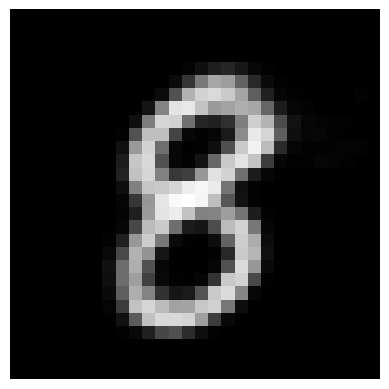

In [77]:
import matplotlib.pyplot as plt

img7 = model.generate_images(8, prior_std=1.0)
plt.imshow(img7.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [85]:
fig, axes = plt.subplots(
    nrows=10,
    ncols=10,
    figsize=(10, 10),
    tight_layout=True
)

for digit in range(10):
    # make a batch of labels all equal to `digit`
    labels = torch.full(
        (10,),
        fill_value=digit,
        dtype=torch.long,
        device=model.device
    )
    # generate images; style_z=None → sampled inside with prior_std
    imgs = model.generate_images(labels, style_z=None, prior_std=PRIOR_STD)

    # plot each sample in its column
    for col in range(10):
        ax = axes[digit, col]
        img = imgs[col].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')

# save to disk
fig.savefig(f'{RESULT_FOLDER}/fig_2', dpi=300, bbox_inches='tight')
plt.close(fig)